## Загрузка и обработка данных

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.48G/1.49G [00:11<00:00, 149MB/s]
100% 1.49G/1.49G [00:12<00:00, 133MB/s]


In [ ]:
!unzip -q 100-bird-species.zip

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.transforms.transforms import ToTensor
from PIL import Image

In [ ]:
data = pd.read_csv('birds.csv')

In [ ]:
data[data['data set']=='train'][:1]

,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train


In [ ]:
#transforms.AutoAugment(Image.open((data[data['data set']=='train']['filepaths'][0])))

In [ ]:
len(np.unique(data['labels']))

401

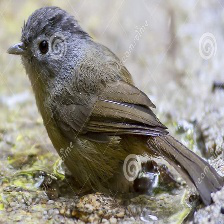

In [ ]:
Image.open((data[data['data set']=='train']['filepaths'][0]))

In [ ]:
uniq_labels = data.labels.unique()
label_index = {label: i for i, label in enumerate(uniq_labels)}

In [ ]:
stand_mean = [0.485, 0.456, 0.406]
stand_std = [0.229, 0.224, 0.225]
base_transform = T.Compose([
                           T.Resize(size=224),
                           T.ToTensor(),
                           T.Normalize(mean=stand_mean, std=stand_std)
])

In [ ]:
class NewDataset(Dataset):
    def __init__(self, img_data, label_index, transform=None):
        self.transform = transform
        self.files = img_data['filepaths']
        self.labels = img_data['labels']
        self.label_index = label_index
    
    def __len__(self):
        return len(self.files)

   
    def __getitem__(self, idx):
        image = Image.open(self.files[idx])#.convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_index[self.labels[idx]])
       


        return {'images': image, 'labels': label}

In [ ]:
train_dataset = NewDataset(data[data['data set'] == 'train'].copy().reset_index(drop=True), label_index, base_transform)
test_dataset = NewDataset(data[data['data set'] == 'test'].copy().reset_index(drop=True), label_index, base_transform)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

##Модель и обучение

In [ ]:
!pip install -q  neptune-client

     |████████████████████████████████| 317 kB 37.9 MB/s 
     |████████████████████████████████| 829 kB 56.8 MB/s 
     |████████████████████████████████| 54 kB 1.2 MB/s 
     |████████████████████████████████| 181 kB 70.2 MB/s 
     |████████████████████████████████| 132 kB 70.3 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 8.8 MB 59.2 MB/s 
     |████████████████████████████████| 138 kB 75.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 127 kB 78.1 MB/s 
     |████████████████████████████████| 130 kB 76.8 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inc

In [ ]:
!pip install pytorch-lightning -q

     |████████████████████████████████| 584 kB 35.8 MB/s 
     |████████████████████████████████| 596 kB 63.4 MB/s 
     |████████████████████████████████| 140 kB 75.5 MB/s 
     |████████████████████████████████| 418 kB 66.5 MB/s 
     |████████████████████████████████| 1.1 MB 48.8 MB/s 
     |████████████████████████████████| 144 kB 65.9 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 271 kB 58.1 MB/s 


In [ ]:
from pytorch_lightning import LightningModule
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import NeptuneLogger
from torch.nn import functional as F
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn

Я взял ResNet, особенностью модели является наличие остаточных связей, которые помогают бороться с затуханием градиента и позволяют строить более глубокие и эффективные сетки 

In [ ]:
from torchvision.models import resnet18

In [ ]:
res_model = resnet18(pretrained=True)

In [ ]:
#res_model

In [ ]:
n_classes = len(label_index)
n_out = 512

In [ ]:

class ClassModel(LightningModule):
    def __init__(self, model, n_out, n_classes):
        super().__init__()
        self.model = model  
        self.model.fc = nn.Linear(n_out, n_classes)

    def accuracy_score(self, logits, targets):
        preds = logits.argmax(1).detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        acc = np.mean(preds==targets)
        return acc
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch['images'], batch['labels']
        logits = self.model(inputs)

        loss = F.cross_entropy(logits, targets)
        acc = self.accuracy_score(logits, targets)

        self.log("Train loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("Train accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch['images'], batch['labels']
        logits = self.model(inputs) 

        loss = F.cross_entropy(logits, targets)
        accuracy = self.accuracy_score(logits, targets)

        self.log("Test loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("Test accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def configure_optimizers(self):
        optim = Adam(self.parameters(), lr=1e-4)
        return {"optimizer": optim, "monitor": "Test loss"}

In [ ]:
model = ClassModel(res_model, n_out, n_classes)

In [ ]:
neptune_logger = NeptuneLogger(
    project="op-maker/cv--hw",
    api_key="#",
    log_model_checkpoints=False,
)

trainer = Trainer(logger=neptune_logger, gpus=1, max_epochs=15)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.4 M
---------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.529    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

https://app.neptune.ai/op-maker/cv--hw/e/CVHW-12
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TypeError: ignored

Обучал на небольшом числе эпох, т.к. был лимит на гпу, но в целом модель обучилась неплохо, у метрики хорошие результаты, а график лосса стал ближе к концу более ровным. Дальнейшее обучение сильных результатов вряд ли бы принесло

Теперь добавим аугментаций, немного изменим оптимайзер(увеличим lr и будем уменьшать его при выходе модели[значений метрики] на плато), добавим еще один слой и посмотрим какой результат это даст

In [ ]:
train_transform = T.Compose([
                            T.Resize(size=224),
                            T.RandomHorizontalFlip(),
                            T.transforms.RandomRotation(22),
                            T.RandomPosterize(3),
                            T.RandomAutocontrast(),
                            T.ToTensor(),
                            T.Normalize(mean=stand_mean, std=stand_std)
 ])

In [ ]:
train_dataset_new = NewDataset(data[data['data set'] == 'train'].copy().reset_index(drop=True), label_index, train_transform)
test_dataset_new = NewDataset(data[data['data set'] == 'test'].copy().reset_index(drop=True), label_index, base_transform)

In [ ]:
train_dataloader_new = DataLoader(train_dataset_new, batch_size=64, shuffle=True)
test_dataloader_new = DataLoader(test_dataset_new, batch_size=64)

In [ ]:
res_model_new = resnet18(pretrained=True)

In [1]:
#res_model_new

In [ ]:
class ClassModel_new(LightningModule):
    def __init__(self, model, n_out, n_classes):
        super().__init__()
        self.model = model 
        self.model.fc = nn.Linear(n_out, n_out)
        self.model.drop = nn.Dropout(p=0.4, inplace=True)
        self.model.fc2 = nn.Linear(n_out, n_classes)

    def accuracy_score(self, logits, targets):
        preds = logits.argmax(1).detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        acc = np.mean(preds==targets)
        return acc
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch['images'], batch['labels']
        logits = self.model(inputs)

        loss = F.cross_entropy(logits, targets)
        acc = self.accuracy_score(logits, targets)

        self.log("Train loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("Train accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch['images'], batch['labels']
        logits = self.model(inputs)

        loss = F.cross_entropy(logits, targets)
        accuracy = self.accuracy_score(logits, targets)

        self.log("Test loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("Test accuracy", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def configure_optimizers(self):
        optim = Adam(self.parameters(), lr=3e-4)
        schedul = ReduceLROnPlateau(optim, factor=0.8, patience=2)
        return {"optimizer": optim, "lr_scheduler": schedul, "monitor": "Test loss"}

In [ ]:
model_new = ClassModel_new(res_model_new, n_out, n_classes)

In [2]:
#model_new

In [ ]:
neptune_logger_new = NeptuneLogger(
    project="op-maker/cv--hw",
    api_key="#",
    log_model_checkpoints=False,
)

trainer_new = Trainer(logger=neptune_logger_new, gpus=1, max_epochs=15)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer_new.fit(model_new, train_dataloader_new, test_dataloader_new)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/.neptune/None/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.6 M
---------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.580    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

https://app.neptune.ai/op-maker/cv--hw/e/CVHW-13
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Как ни странно, эта модель показала результат хуже, чем первая(можно увидеть из графика сравнения). Есть предположение, что данные аугментации оказались неудачными, возможно, стоило сделать reducelr более чувствительной, а вероятность дропаута поменьше. Но в целом эта моделька так же сходится